<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/segmentaci%C3%B3n_sem%C3%A1ntica/segmentaci%C3%B3n_de_im%C3%A1genes_con_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA44KEF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteA44KEF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
dataset.keys()

dict_keys(['train', 'test'])

In [7]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpegddjde5tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [22]:
def random_flip(input_image, input_mask):
    # Giro aleatorio de la imagen y la máscara
    if tf.random.uniform(())>0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask  = tf.image.flip_left_right(input_mask)    
    return input_image, input_mask

def normalize(input_image, input_mask):
    # Normaliza los valores de píxeles de la imagen entre [0, 1]. Resta 1 de las etiquetas de máscara para tener un rango de [0, 2].
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    # Redimensiona, normaliza y voltea los datos de entrenamiento
    input_image = tf.image.resize(datapoint["image"], (128, 128), method="nearest")
    input_mask  = tf.image.resize(datapoint["segmentation_mask"], (128, 128), method="nearest")  
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    # Redimensiona y normaliza los datos de prueba
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [11]:
train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

In [12]:
batch_size = 64
buffer_size = 1000

# Mezcla y agrupa el conjunto de entrenamiento en lotes
train_dataset = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Se hace una precarga para optimizar el procesamiento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Agrupa el conjunto de prueba en lotes
test_dataset = test.batch(batch_size)

In [13]:
class_names = ['pet', 'background', 'outline']

In [20]:
def display_with_metrics(display_list, iou_list, dice_score_list):
    # Muestra una lista de imágenes/máscaras y superpone una lista de puntajes de IOU y Dice Score
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
    # Muestra una lista de imágenes/máscaras
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    plt.show()


def show_image_from_dataset(dataset):
    # Muestra la primera imagen y su máscara del conjunto de datos
    for image, mask in dataset.take(42):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
    # Visualiza la métrica del modelo
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

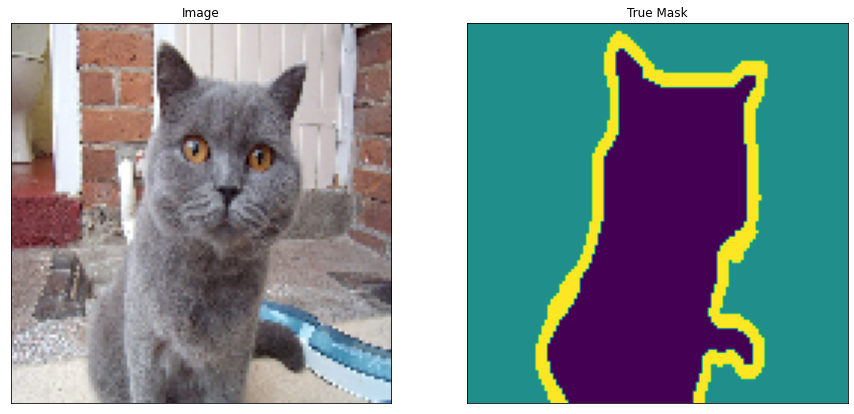

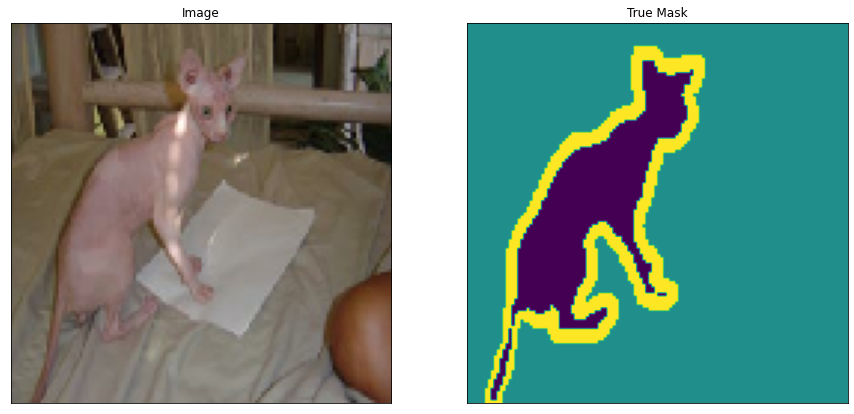

In [21]:
# Muestra una imagen del conjunto de entrenamiento
show_image_from_dataset(train)

# Muestra una imagen del conjunto de prueba
show_image_from_dataset(test)

### POR HACER

* Definir arquitectura del modelo (U-Net)
* Entrenar y evaluar modelo
* Hacer predicciones
* Añadir referencias